In [1]:
# Her0 helpers
import BBVAHer0.preprocessing as Pp
import BBVAHer0.metrics as Mtr

# Core libs
import pandas as pd
import numpy as np
import importlib

importlib.reload(Pp)
importlib.reload(Mtr)

# Graphic libs
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
pio.renderers.default = "browser"

# sklearn 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_absolute_percentage_error as LMAPE

# IA + blockchain = profit
import tensorflow as tf
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Lambda, Dropout, BatchNormalization, Activation, Dense, LeakyReLU, Add
from keras.layers.merging import Add, Concatenate
from keras.utils import plot_model, to_categorical

2022-12-09 02:11:15.835768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 02:11:16.637307: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-09 02:11:17.816228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-09 02:11:17.816339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
raw_data_master = pd.read_excel('../data/xlsx/ord80p.xlsx', header = [0]).applymap(lambda x : (x - pd.Timestamp("1900-01-01 00:00:00")).days + 2 if isinstance(x,pd.Timestamp) else x)
raw_test_master = pd.read_excel('../data/xlsx/ord20p.xlsx', header = [0]).applymap(lambda x : (x - pd.Timestamp("1900-01-01 00:00:00")).days + 2 if isinstance(x,pd.Timestamp) else x)

In [3]:
importlib.reload(Pp)
importlib.reload(Mtr)

trainer_data, train_gt = Pp.sanitize(raw_data_master, True)
tester_data, test_gt = Pp.sanitize(raw_data_master, True)
log_data = trainer_data.drop(['Valorcomercial'], axis=1)
log_test = tester_data.drop(['Valorcomercial'], axis=1)

In [6]:
fig = px.scatter_matrix(trainer_data,
    #dimensions=['PC '+ str(i+1) + ' ' + '({:.2f}%)'.format(pca.explained_variance_ratio_[i]*100) for i in range(1,13)],
    #color="Valor comercial (USD)",
    title="Scatter matrix of data set",
    labels=trainer_data.columns) # remove underscore
fig.update_traces(diagonal_visible=False)
fig.update_traces(marker_size=1)

fig.update_layout(font=dict(size=10))

fig.update_layout({"xaxis"+str(i+1): dict(showticklabels = False, title=trainer_data.columns[i][:3].upper()) for i in range(8)})
fig.update_layout({"yaxis"+str(i+1): dict(showticklabels = False, title=trainer_data.columns[i][:3].upper()) for i in range(8)})


fig.update_layout(margin={"r":150,"t":20,"l":150,"b":20})
fig.show()

/home/ric/Documents/Code/hackathonBBVA/venv/lib/python3.10/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [6]:
trainer_data.describe()

,Lat,Long,Categoriadelbien,Edad,Areaterreno,Areaconstruccion,Valorcomercial
count,28774.000000,28774.000000,28774.000000,28774.000000,28774.000000,28774.000000,28774.000000
mean,-2.263190,-4.193688,1.335604,1.865950,4.431212,5.076233,62.278120
std,0.269159,0.505336,0.380319,1.243425,5.435525,2.421045,24.360705
min,-4.255516,-9.129394,0.004642,0.004642,0.004642,0.004642,2.758924
25%,-2.296839,-4.255290,1.259921,1.000000,2.286882,4.173702,48.039103
50%,-2.295076,-4.254701,1.259921,1.912931,3.133592,4.754843,56.898455
75%,-2.293360,-4.253983,1.442250,2.802039,5.428835,5.874717,69.770336
max,0.004642,0.004642,2.351335,12.609701,468.755196,35.523294,329.403330


In [4]:
data_pca = PCA()
data_pca.fit(trainer_data)

print(['PC'+str(i+1)+' ({:.3f})%'.format(data_pca.explained_variance_ratio_[i]*100) for i in range(7)])
print(np.cumsum(data_pca.explained_variance_ratio_)*100)

['PC1 (98.004)%', 'PC2 (1.165)%', 'PC3 (0.497)%', 'PC4 (0.198)%', 'PC5 (0.066)%', 'PC6 (0.048)%', 'PC7 (0.021)%']
[ 98.00415797  99.16879764  99.66598786  99.86405682  99.9304733
  99.97876263  99.99928796 100.        ]


In [5]:
X = trainer_data.to_numpy().T
components = (data_pca.components_[:5,:]@X).T

components.shape

(27426, 5)

In [10]:
components_df = pd.DataFrame(components, columns=['PC'+str(i+1)+' ({:.1f})%'.format(data_pca.explained_variance_ratio_[i]*100) for i in range(8)])
components_df.insert(0, 'Valorcomercial', trainer_data['Valorcomercial'].to_numpy())

fig = px.scatter_matrix(components_df,
    dimensions=['PC'+str(i+1)+' ({:.1f})%'.format(data_pca.explained_variance_ratio_[i]*100) for i in range(8)],
    color="Valorcomercial",
    title="PCA Pairs plot",
    labels=components_df.columns) # remove underscore
fig.update_traces(diagonal_visible=False)
fig.update_traces(marker_size=1)

fig.update_layout(font=dict(size=10))

fig.update_layout({"xaxis"+str(i+1): dict(showticklabels = False) for i in range(8)})
fig.update_layout({"yaxis"+str(i+1): dict(showticklabels = False, title='PC'+str(i+1)) for i in range(8)})


fig.update_layout(margin={"r":150,"t":20,"l":150,"b":20})

fig.show()

/home/ric/Documents/Code/hackathonBBVA/venv/lib/python3.10/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


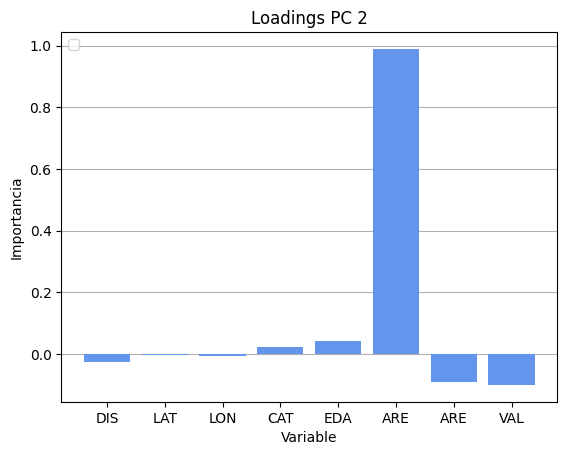

In [24]:
fig, ax = plt.subplots()

ax.set_title('Loadings PC 2')
ax.bar(range(1,9),data_pca.components_[1], color='cornflowerblue')
ax.set_ylabel('Importancia')
ax.set_xlabel('Variable')
ax.set_xticks(range(1,9),[trainer_data.columns[i][:3].upper() for i in range(8)])
ax.legend(loc='upper left')

#add horizontal gridlines behind bars in the plot
ax.set_axisbelow(True)
ax.grid(axis='y')

#display plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


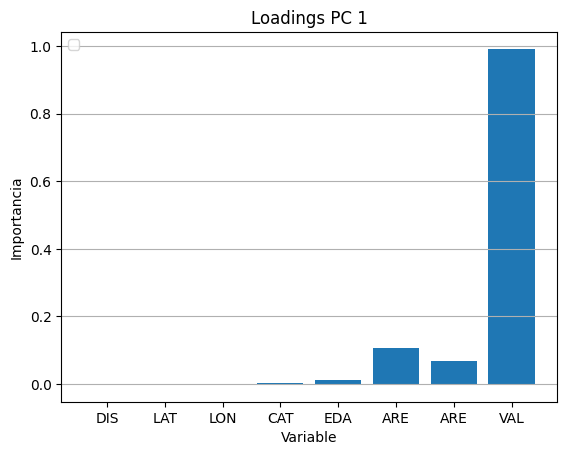

In [18]:
plt.grid(axis='y')
plt.title('Loadings PC 1')
plt.bar(range(1,9),data_pca.components_[0] )
plt.ylabel('Importancia')
plt.xlabel('Variable')
plt.xticks(range(1,9),[trainer_data.columns[i][:3].upper() for i in range(8)])
plt.legend(loc='upper left')
#plt.axisbelow(True)
plt.show()

In [8]:
fig = px.scatter(x=list(range(1,9)), y=data_pca.components_[0])
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(1,9)),
        ticktext = [trainer_data.columns[i][:3].upper() for i in range(8)]
    )
)
fig.show()

In [17]:
Xin = Input(shape=(8,),name='In')
#X = Dense(7,activation='relu')(Xin)
#X = Dense(7,activation='relu')(X)
#X = Dense(7,activation='relu')(X)
#X = Dense(7,activation='relu')(X)
X = Dense(10)(Xin)
X = LeakyReLU()(X)
X = Dense(10)(X)
X = LeakyReLU()(X)
X = Dense(10)(X)
X = LeakyReLU()(X)
X = Dense(10)(X)
X = LeakyReLU()(X)
X = Dense(10)(X)
X = LeakyReLU()(X)
X = Dense(10)(X)
#X = Dense(7,activation=tf.keras.activations.softsign)(X)
#X = Dense(7,activation=tf.keras.activations.softsign)(X)
X = Dense(8)(X)
completion = LeakyReLU()(X)

S4D_jengi = Model(inputs = Xin, outputs = [completion], name = "S4D_Jengi")

#full_pca_inference = Concatenate(axis=1, name = 'completion')([Xin,completion])
full_pca_inference = Add(name = 'completion')([Xin,completion])
Yout = Lambda(lambda x : tf.transpose(data_pca.components_[:5,:]@tf.transpose(x)))(full_pca_inference)

Jengi_train = Model(inputs = Xin, outputs = [Yout], name = 'PCA_train')

In [34]:
#S4D_jengi.save_weights("S4D_Her0/S4D_jengi.h5")

In [20]:
#importlib.reload(Mtr)

epochs     = 1500        # número de epocas
batch_size = 1000         # tamaño del lote
alpha      = 0.001     # razon de aprendizaje
decay      = 0.0001    # decaimiento de alpha

Jengi_train.compile(optimizer = optimizers.Adam(learning_rate=alpha, decay=decay),
                    loss      = 'mse',
                    metrics   = ['accuracy'])

#Jengi_train.summary()

history = Jengi_train.fit(x                = np.concatenate([log_data, np.zeros((log_data.shape[0],1))], axis = 1),
                          y                = components,
                          batch_size       = batch_size,
                          epochs           = epochs,
                          validation_split = 0.2,
                          verbose          = 1)

Epoch 1/1500
22/22 [==============================] - 1s 12ms/step - loss: 26.8751 - accuracy: 0.9999 - val_loss: 34.0407 - val_accuracy: 0.9998
Epoch 2/1500
22/22 [==============================] - 0s 5ms/step - loss: 26.3411 - accuracy: 0.9999 - val_loss: 33.8428 - val_accuracy: 0.9998
Epoch 3/1500
22/22 [==============================] - 0s 5ms/step - loss: 26.3540 - accuracy: 0.9999 - val_loss: 33.0763 - val_accuracy: 0.9998
Epoch 4/1500
22/22 [==============================] - 0s 7ms/step - loss: 26.2978 - accuracy: 0.9999 - val_loss: 33.4816 - val_accuracy: 0.9998
Epoch 5/1500
22/22 [==============================] - 0s 6ms/step - loss: 26.2419 - accuracy: 0.9999 - val_loss: 33.3524 - val_accuracy: 0.9998
Epoch 6/1500
22/22 [==============================] - 0s 5ms/step - loss: 26.2963 - accuracy: 0.9999 - val_loss: 33.4380 - val_accuracy: 0.9998
Epoch 7/1500
22/22 [==============================] - 0s 7ms/step - loss: 26.4976 - accuracy: 0.9999 - val_loss: 34.2315 - val_accuracy

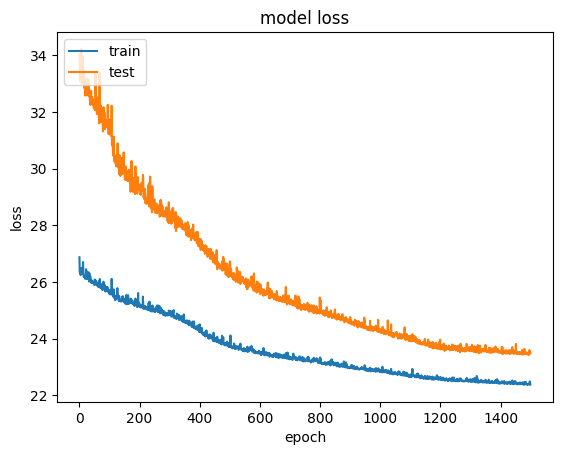

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [173]:
Xin = Input(shape=(12,),name='In')
X = Jengi_train(Xin)
X = Dense(2,activation=tf.keras.activations.softsign)(X)
X = Dense(12,activation=tf.keras.activations.softsign)(X)
Yout = Dense(1, activation='relu')(X)

S4D_Her0 = Model(inputs = Xin, outputs = [Yout], name = "S4D_Her0")

for layer in S4D_Her0.layers:
    if layer.name in ['PCA_train']:
        print("PCA Locked!!")
        layer.trainable = False
    else:
        layer.trainable = True

PCA Locked!!


In [65]:
epochs     = 500        # número de epocas
batch_size = 1000         # tamaño del lote
alpha      = 10     # razon de aprendizaje
decay      = 0.0001    # decaimiento de alpha

S4D_Her0.compile(optimizer  = optimizers.Adam(learning_rate=alpha, decay=decay),
                  loss      = 'mae',
                  metrics   = [Mtr.mape_accuracy_p3])

history = S4D_Her0.fit(x                 = log_data,
                        y                = train_gt,
                        batch_size       = batch_size,
                        epochs           = epochs,
                        validation_split = 0.2,
                        verbose          = 1)

NameError: name 'S4D_Her0' is not defined

In [21]:
log_test['Categoriadelbien']**3 == 2

0        False
1        False
2        False
3        False
4        False
         ...  
42599    False
42600    False
42601    False
42602    False
42603    False
Name: Categoriadelbien, Length: 42604, dtype: bool

In [176]:
S4D_jengi.compile(loss      = tf.losses.MeanAbsolutePercentageError(),
                  metrics   = [Mtr.mape_accuracy_p3, 'mse'])

score = S4D_jengi.evaluate(log_test, tester_data['Valorcomercial'].to_numpy(), verbose=1)

39/39 [==============================] - 0s 2ms/step - loss: 14.8729 - mape_accuracy_p3: 19.6141 - mse: 251.5887


In [22]:
res = S4D_jengi.predict(np.concatenate([log_test, np.zeros((log_test.shape[0],1))], axis = 1))

858/858 [==============================] - 1s 990us/step


In [23]:
cbrtval = res.T[-1]

In [24]:
LMAPE(test_gt, cbrtval**3)

0.5332726605764517

In [94]:
cbrtval[:10]**3

array([ 151746.73 ,  326462.66 ,  146746.42 ,  110192.7  ,   65923.43 ,
        115219.234,  182989.84 , 1679260.8  ,   64933.875,  897221.44 ],
      dtype=float32)

In [93]:
test_gt[:10]

array([ 160437,  294567,  124749,   97169,   12187,   57076,  217165,
       7016452,   30683,  815163])

In [27]:
scale_res = cbrtval**3
mape_list = np.array([ np.abs((test_gt[i] - scale_res[i])/test_gt[i])*100 for i in range(test_gt.shape[0])])
#mape_list = np.array([val if val < 200 else 300 for val in mape_list])

In [28]:
mape_list.shape

(27426,)

In [29]:
data2_pca = PCA()
data2_pca.fit(res)
X = trainer_data.to_numpy().T
components = (data_pca.components_@X).T

components.shape

(27426, 8)

In [103]:
components_df = pd.DataFrame(components, columns=['PC'+str(i+1)+' ({:.1f})%'.format(data_pca.explained_variance_ratio_[i]*100) for i in range(8)])
#components_df.insert(0, 'Valorcomercial', trainer_data['Valorcomercial'].to_numpy())
components_df.insert(0, 'Valorcomercial', cbrtval)

fig = px.scatter_matrix(components_df,
    dimensions=['PC'+str(i+1)+' ({:.1f})%'.format(data_pca.explained_variance_ratio_[i]*100) for i in range(8)],
    color=tier,#np.array([val if val < 200 else 300 for val in mape_list]),
    title="PCA Pairs plot",
    labels=components_df.columns) # remove underscore
fig.update_traces(diagonal_visible=False)
fig.update_traces(marker_size=1)

fig.update_layout(font=dict(size=10))

fig.update_layout({"xaxis"+str(i+1): dict(showticklabels = False) for i in range(8)})
fig.update_layout({"yaxis"+str(i+1): dict(showticklabels = False, title='PC'+str(i+1)) for i in range(8)})


fig.update_layout(margin={"r":150,"t":20,"l":150,"b":20})

fig.show()

/home/ric/Documents/Code/hackathonBBVA/venv/lib/python3.10/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [30]:
np.mean(mape_list)

53.32726605764517

In [31]:
tier = []
mu = np.mean(mape_list)
sigma = np.std(mape_list)
for val in mape_list:
    if val <= 10:
        tier.append('Correct')
        continue
    if val <= 25:
        tier.append('Acceptable')
        continue
    if val <= 100:
        tier.append('Approximate')
        continue
    if val <= (mu + sigma):
        tier.append('In range')
        continue
    else:
        tier.append('Annomaly')

tier = np.array(tier)

In [32]:
tier[tier == 'Correct'].shape[0] + tier[tier == 'Acceptable'].shape[0]

14991

In [79]:
res

array([[27.977018  , 12.761486  , -0.33191112, ...,  0.516688  ,
         1.5467876 , 53.357975  ],
       [35.227562  , 16.083914  , -0.42365462, ...,  0.6507887 ,
         1.9488229 , 67.15997   ],
       [27.601126  , 12.589657  , -0.32717586, ...,  0.510366  ,
         1.526387  , 52.645046  ],
       ...,
       [29.148487  , 13.295793  , -0.34638256, ...,  0.5351874 ,
         1.6110816 , 55.57518   ],
       [32.561676  , 14.861186  , -0.38977233, ...,  0.6000124 ,
         1.8005797 , 62.079388  ],
       [31.148556  , 14.21327   , -0.3717548 , ...,  0.57497466,
         1.7236813 , 59.390217  ]], dtype=float32)

In [96]:
fig = px.scatter_matrix(res+tester_data,
    dimensions=tester_data.columns,
    title="Scatter matrix of data set",
    color=cbrtval,
    labels=tester_data.columns) # remove underscore
fig.update_traces(diagonal_visible=False)
fig.update_traces(marker_size=1)

fig.update_layout(font=dict(size=10))

fig.update_layout({"xaxis"+str(i+1): dict(showticklabels = False, title=tester_data.columns[i][:3].upper()) for i in range(8)})
fig.update_layout({"yaxis"+str(i+1): dict(showticklabels = False, title=tester_data.columns[i][:3].upper()) for i in range(8)})

fig.update_layout(margin={"r":150,"t":20,"l":150,"b":20})
fig.show()

/home/ric/Documents/Code/hackathonBBVA/venv/lib/python3.10/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [64]:
fig = px.scatter_matrix(res,
    dimensions=[0,1,2,3,4,5,6,7],
    title="Scatter matrix of data set",
    color=tier,
    labels=tester_data.columns) # remove underscore
fig.update_traces(diagonal_visible=False)
fig.update_traces(marker_size=1)

fig.update_layout(font=dict(size=10))

fig.update_layout({"xaxis"+str(i+1): dict(showticklabels = False, title=tester_data.columns[i][:3].upper()) for i in range(8)})
fig.update_layout({"yaxis"+str(i+1): dict(showticklabels = False, title=tester_data.columns[i][:3].upper()) for i in range(8)})

fig.update_layout(margin={"r":150,"t":20,"l":150,"b":20})
fig.show()

/home/ric/Documents/Code/hackathonBBVA/venv/lib/python3.10/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [36]:
pred_train = S4D_jengi.predict(np.concatenate([log_data, np.zeros((log_data.shape[0],1))], axis = 1))
scale_res = (pred_train.T[-1])**3
train_mape = np.array([ np.abs((train_gt[i] - scale_res[i])/train_gt[i])*100 for i in range(train_gt.shape[0])])

pred_test =  S4D_jengi.predict(np.concatenate([log_data, np.zeros((log_data.shape[0],1))], axis = 1))
scale_res = (pred_test.T[-1])**3
test_mape = np.array([ np.abs((test_gt[i] - scale_res[i])/test_gt[i])*100 for i in range(test_gt.shape[0])])

858/858 [==============================] - 1s 1ms/step


In [42]:
cat_train = [0 if val < 25 else 1 for val in train_mape]
cat_test = [0 if val < 25 else 1 for val in test_mape]

In [43]:
onehot_train = to_categorical(cat_train)

In [60]:
Xin = Input(shape=(8,),name='In')
X = Dense(30)(Xin)
X = LeakyReLU()(X)
X = Dense(30)(X)
X = LeakyReLU()(X)
X = Dense(30)(X)
X = LeakyReLU()(X)
X = Dense(30)(X)
X = LeakyReLU()(X)
X = Dense(30)(X)
X = LeakyReLU()(X)
X = Dense(30)(X)
X = LeakyReLU()(X)
X = Dense(2)(X)
Yout = LeakyReLU()(X)

S4D_astra = Model(inputs = Xin, outputs = [Yout], name = "S4D_Astra")

In [63]:
epochs     = 1500        # número de epocas
batch_size = 1000         # tamaño del lote
alpha      = 10     # razon de aprendizaje
decay      = 0.0001    # decaimiento de alpha

S4D_astra.compile(optimizer  = optimizers.Adam(learning_rate=alpha, decay=decay),
                  loss      = 'mse',
                  metrics   = ['accuracy'])

history = S4D_astra.fit(x                 = pred_train,
                        y                 = onehot_train,
                        batch_size        = batch_size,
                        epochs            = epochs,
                        validation_split  = 0.2,
                        verbose           = 1)

Epoch 1/1500
22/22 [==============================] - 1s 8ms/step - loss: nan - accuracy: 0.5476 - val_loss: nan - val_accuracy: 0.5427
Epoch 2/1500
22/22 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.5476 - val_loss: nan - val_accuracy: 0.5427
Epoch 3/1500
22/22 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.5476 - val_loss: nan - val_accuracy: 0.5427
Epoch 4/1500
22/22 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.5476 - val_loss: nan - val_accuracy: 0.5427
Epoch 5/1500
22/22 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.5476 - val_loss: nan - val_accuracy: 0.5427
Epoch 6/1500
22/22 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.5476 - val_loss: nan - val_accuracy: 0.5427
Epoch 7/1500
22/22 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.5476 - val_loss: nan - val_accuracy: 0.5427
Epoch 8/1500
22/22 [============================

KeyboardInterrupt: 